<h1>Soccermatics</h1>
<h3>Assignment 1</h3>
<h6>Instructions</h6>
<ol>
<li>Think of a player who you enjoyed watching at the recent Men's Euros 2020 or Women's Euros 2022.</li>
<li>What actions did they perform that were important and why?</li>
<li>Plot the actions and describe how the data supports or contradicts your own analysis.</li>
<li>Collect some statistics on that player for the tournament and put them in context.</li>
<li>Write a short text using at most two figures that illustrate your point.</li>
</ol>
I have chosen the Men's Euros 2020 as England is my favourite European team.

I analysed Declan's passes with emphasis on his long passes that progressed the ball at least 10 yards.

#### Import libraries and set variables

In [25]:
import pandas as pd
import numpy as np

import inflect

import matplotlib as mpl
import matplotlib.pyplot as plt
from mplsoccer import Sbopen, Pitch

In [26]:
COLOUR_BACKGROUND = '#f7f3ed'
COLOUR_ALMOST_BLACK = '#323232'
COLOUR_BLUE = '#1c7ed6'
COLOUR_PINK = '#d6336c'

In [27]:
STATSBOMB_HALFWAY = 60

In [28]:
euro_competition_id = 55
euro_season_id = 43

#### Getting every match at Euros 2020

In [29]:
parser = Sbopen()
df_matches = parser.match(competition_id=euro_competition_id, season_id=euro_season_id)

In [30]:
# Getting only matches played by England as the home or away team
df_matches_england=df_matches[(df_matches['home_team_name']=="England") | (df_matches['away_team_name']=="England")].sort_values('kick_off')

In [31]:
# Getting event, related_events etc data for all England matches
events = {}
related_events = {}
freezes = {}
tactics = {}

for match_id in df_matches_england['match_id']:
    events[match_id], related_events[match_id], freezes[match_id], tactics[match_id] = parser.event(match_id)

#### Different functions

In [32]:
'''
This function filters a DataFrame to return only rows that meet certain conditions, specifically for a given player name, 
event type, pass length greater than 20 and subtype of event is not throw-in.
'''

def filter_for_player_and_event(df, player_name, event_type_name):
    df_filtered = df[(df['player_name']==player_name)&(df['type_name']==event_type_name)&(df['pass_length']>20)&(df['sub_type_name']!='Throw-in')]
    return df_filtered

In [33]:
'''
This function plots events on a graph, it filters out events that are not long passes and separates them based on if they 
occured in attacking or defensive half of the field. It also keeps count of the number of long passes from each half of the 
field and returns the plotted circles and arrows, and the counts of long passes.
'''

def plot_lines(df, colour_attacking_half, colour_defensive_half,min_dx=10):
    long_passes_from_attacking_half = 0
    long_passes_from_defensive_half = 0

    circles = []
    arrows  = []
    
    for i, event in df.iterrows():
        dx = event['end_x']-event['x']
        dy = event['end_y']-event['y']
        
        if dx >= min_dx: # to exclude passes that go towards defending area instead of attacking and are less than 10 yards
            if event['x'] > STATSBOMB_HALFWAY:
                    colour = colour_attacking_half
                    long_passes_from_attacking_half += 1
            else:
                colour = colour_defensive_half
                long_passes_from_defensive_half += 1

            circle = plt.Circle((event['x'], event['y']), 1.5, color=colour)
            circle.set_alpha(.2)
            circles.append(circle)

            arrow = mpl.patches.FancyArrowPatch((event['x'], event['y']),
                                (event['end_x'], event['end_y']), arrowstyle='-|>', color=colour, alpha=0.7, mutation_scale=15)
            arrows.append(arrow)

    return circles, arrows, long_passes_from_attacking_half, long_passes_from_defensive_half

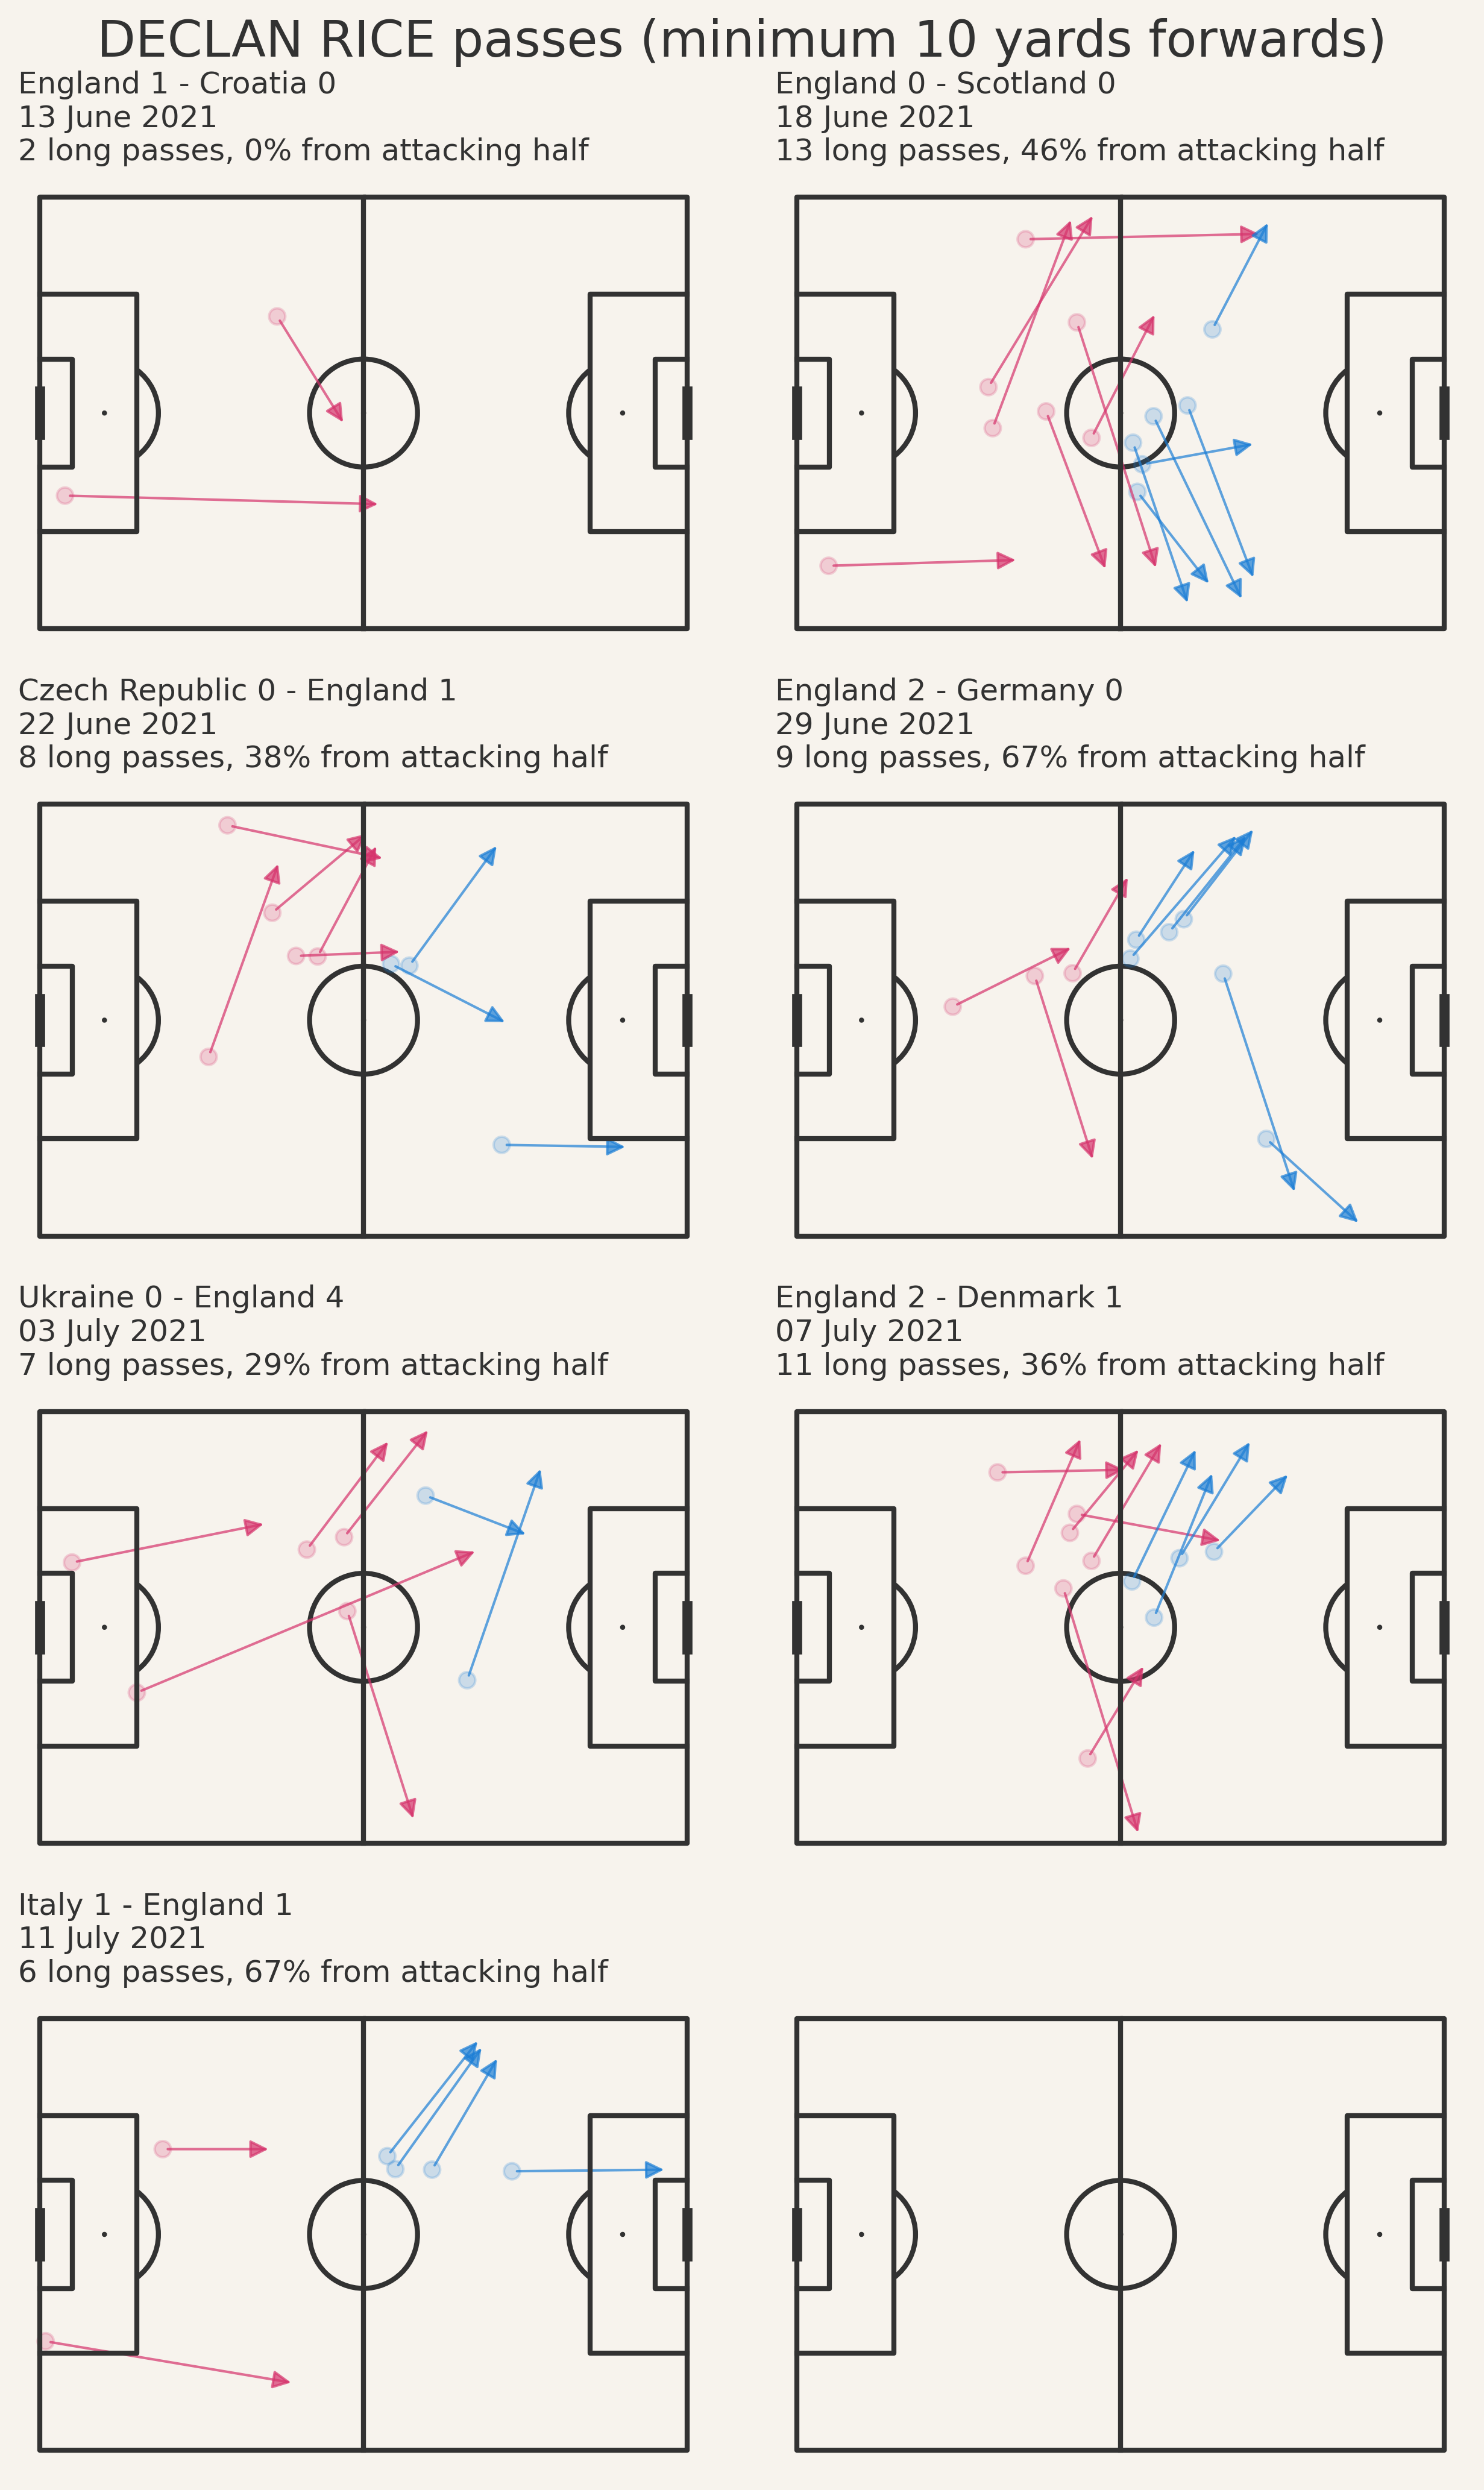

In [34]:
'''
This code creates a visual representation of the passing events of a specific player, Declan Rice, on a soccer field for 
multiple matches using two functions defined earlier. It filters out the events to only include long passes and plots them 
on the field. It also calculates statistics on the long passes and labels the final plot with the match details, passing 
statistics and player name.
'''

player_name = 'Declan Rice'
event_type_name = 'Pass'
min_dx = 10 # this is yards, not metres

pitch = Pitch(pitch_color=COLOUR_BACKGROUND, line_color=COLOUR_ALMOST_BLACK,
              line_zorder=1)

fig, ax = pitch.draw(nrows=4, ncols=2, figsize=(10,14))

fig.patch.set_facecolor(COLOUR_BACKGROUND)

for i, match_id in enumerate(events.keys()):
    df_temp = events[match_id]
    home_team_country = df_matches[df_matches['match_id']==match_id]['home_team_name'].iloc[0]
    home_team_score   = df_matches[df_matches['match_id']==match_id]['home_score'].iloc[0]
    away_team_country = df_matches[df_matches['match_id']==match_id]['away_team_name'].iloc[0]
    away_team_score   = df_matches[df_matches['match_id']==match_id]['away_score'].iloc[0]
    match_date        = df_matches[df_matches['match_id']==match_id]['match_date'].iloc[0]
    match_name = home_team_country + ' ' + str(home_team_score) + ' - ' + away_team_country + ' ' + str(away_team_score) + '\n' + match_date.strftime('%d %B %Y')

    df_player_events = filter_for_player_and_event(df_temp, player_name, event_type_name)

    circles, arrows, long_passes_from_attacking_half, long_passes_from_defensive_half = plot_lines(df_player_events, colour_attacking_half=COLOUR_BLUE, colour_defensive_half=COLOUR_PINK,min_dx=min_dx)
    for circle in circles:
        ax.flatten()[i].add_patch(circle)
    for arrow in arrows:
        ax.flatten()[i].add_patch(arrow)

    total_long_passes = long_passes_from_attacking_half + long_passes_from_defensive_half
    percent_from_attacking_half = long_passes_from_attacking_half / total_long_passes

    subplot_title = match_name + '\n' + str(total_long_passes) + ' long passes, ' + f'{percent_from_attacking_half:.0%}' + ' from attacking half'

    ax.flatten()[i].set_title(subplot_title, color=COLOUR_ALMOST_BLACK, ha='left', loc='left')

    
if min_dx:
    title_additional = ' (minimum ' + str(min_dx) + ' yards forwards)'
    

p = inflect.engine()

fig.suptitle(player_name.upper() + ' ' + p.plural(event_type_name.lower()) + title_additional, color=COLOUR_ALMOST_BLACK,fontsize=20);
plt.savefig("project1",bbox_figure="tight",dpi=300)